### Solution Explanation:

In [1]:
!nvidia-smi

Tue Apr 26 00:11:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation/'

/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation


### Load Training Data

In [4]:
import pickle
import numpy as np

train_input = pickle.load(open('DS_5_train_input', 'rb'))
train_output = pickle.load(open('DS_5_train_output', 'rb'))

# check dimension
print(type(train_input), type(train_input[0]), len(train_input))
print(type(train_output), type(train_output[0]), len(train_output))

# get the max num of words in train input and output to determine sequence_length
# get the max length of a word to determine vocabulary size

max_ct = 0
max_len = 0
vocab_set = set()
for text in train_input:
  ct = len(text.split())
  for word in text.split():
    vocab_set.add(word)
    length = len(word)
    max_len = max(max_len, length)
  max_ct = max(max_ct, ct)

print('vocab_size in train_input:', len(vocab_set))
print('max num of words in train_input:', max_ct)
print('max length of a word in train_input:', max_len)
print()

max_ct = 0
max_len = 0
vocab_set = set()
for text in train_output:
  ct = len(text.split())
  for word in text.split():
    vocab_set.add(word)
    length = len(word)
    max_len = max(max_len, length)  
  max_ct = max(max_ct, ct)

print('vocab_size in train_output:', len(vocab_set))
print('max num of words in train_output:', max_ct)
print('max length of a word in train_output:', max_len)

<class 'list'> <class 'str'> 5000
<class 'list'> <class 'str'> 5000
vocab_size in train_input: 11
max num of words in train_input: 64
max length of a word in train_input: 1

vocab_size in train_output: 34
max num of words in train_output: 95
max length of a word in train_output: 2


#### Preprocess Data

In [5]:
# insert [start] and [end] to the output language

text_pairs = []
for i in range(len(train_input)):
  input = train_input[i]
  output = "[start] " + train_output[i].strip() + " [end]" # strip off the whitespaces
  text_pairs.append((input, output))

In [6]:
# check sample text pairs
from numpy import random

num_sample = 10
idx = [random.randint(0, len(train_input)) for i in range(num_sample)]

for i in idx:
  print("idx =", i)
  print(len(text_pairs[i][0].split()), text_pairs[i][0])
  print("->")
  print(len(text_pairs[i][1].split())-2, text_pairs[i][1])
  print()

idx = 916
46 a f b f a j a e c d c d a f a k b e a d b g a k c g a k a f b d c d c f a f c e a f b e c g 
->
68 [start] b f c d a e e c d b e b g c g b d c d a f k l c f a k m ed a k j ee a d i ef a k h eg c e b e c g a f ej ek a f ei el a f eh em a j f g fd a f d fe [end]

idx = 3448
32 a i a j a d b f a e a d a f c d b e b d b e b f a d b e c d b g 
->
47 [start] b f c d b e a f e f b d a d g h a e i a d d j b e b f a j k l m b e c d a d ee ef b g a i ed eg eh [end]

idx = 322
58 a g a j b d a f b d c e c f a e a d a g a d b e b f a h c g a k a d a f b g a f a g b g c d a e b e c f c g b f b d 
->
86 [start] b d b d c e a f e f c f a j d g h b e b f a d j k c g b g b g c d a g ee ef b e a e eh a f eg ei a f ed ej c f a d ek el c g a k em fd b f a h m fe ff a g l fg b d a d fh fi a e fj a g i fk [end]

idx = 717
40 a h c d a d a j c e c f c g a f c d a g a k a e c d a e a g c g a e c f b g c e 
->
59 [start] c d c e c f c g a j e f g c d c d a e j c g c f a e m a g l ed a e ee a k k e

#### Split training data into train and val set

In [7]:
import random

random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:]

print(len(train_pairs))
print(len(val_pairs))

4250
750


In [8]:
# save text_pairs
import pickle

with open('text_pairs', "wb") as out_file:
  pickle.dump(text_pairs, out_file)

# with open('train_pairs', "wb") as out_file:
#   pickle.dump(train_pairs, out_file)

# with open('val_pairs', "wb") as out_file:
#   pickle.dump(val_pairs, out_file)

#### Vectorizing the input and output text pairs

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import string
import re

strip_chars = string.punctuation
# print(type(strip_chars))

strip_chars = strip_chars.replace("[", "") # will keep [start] and [end] as it is to separate the marker from actual word start and end
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "") # replace punctuation characters with the empty string

input_vocab_size = 100
output_vocab_size = 100

sequence_length = 100 # max seq length seen in train data is 95

source_vectorization = layers.TextVectorization(
    max_tokens=input_vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=output_vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_input_texts = [pair[0] for pair in text_pairs] # here use all given training data
train_output_texts = [pair[1] for pair in text_pairs]

source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

print(len(source_vectorization.get_vocabulary()))
print(len(target_vectorization.get_vocabulary()))

13
38


#### Preparing datasets for the translation task

In [10]:
batch_size = 64

def format_dataset(input, output):
    input = source_vectorization(input)
    output = target_vectorization(output)
    return ({
        "input": input,
        "output": output[:, :-1],
      }, output[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

print(type(val_ds))

for inputs, targets in train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'>
inputs['input'].shape: (64, 100)
inputs['output'].shape: (64, 100)
targets.shape: (64, 100)


### Use Transformer for Machine Translation

#### Transformer Encoder

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### Using positional encoding to re-inject order information

In [12]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Transformer Decoder

In [13]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Text Decoder

In [14]:
import numpy as np

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100

def strip_markers(sentence):
  # strip the leading [start] and tailing [end] if existing

  words = sentence.split()
  if words[0] == "[start]":
    clean_words = words[1:]
  else:
    clean_words = words
  
  if clean_words[-1] == "[end]":
    clean_words = clean_words[:-1]
  else:
    clean_words = clean_words

  clean_text = " ".join(clean_words)
  return clean_text

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence

#### End-to-end Transformer

In [15]:
embed_dim = 256
dense_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, input_vocab_size, embed_dim)(encoder_inputs)
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) # stack up transformerencoder layers
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, input_vocab_size, embed_dim)(decoder_inputs)
# x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(output_vocab_size, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

#### Train the sequence-to-sequence Transformer

In [16]:
# check how the accuracy metric is calculated in Keras
import tensorflow as tf

m = tf.keras.metrics.Accuracy()
m.update_state([[1,100], [2, 200]], [[1, 200], [3, 300]])
m.result().numpy()

0.25

In [17]:
import tensorflow as tf

# turns out the Keras metric acc is very close to the word accuracy, no need for customied callbacks
"""
def calculate_word_acc(target_texts, pred_texts):

  total_ct = 0
  match_ct = 0

  assert(len(target_texts)==len(pred_texts)) # assert target sentence number match pred sentence number
  
  text_pairs = zip(target_texts, pred_texts) 
  for pair in text_pairs: # loop through each sentence
    target = pair[0]
    pred = pair[1]

    target_words = target.split()
    pred_words = pred.split()

    total_ct += len(target_words)
    min_len = min(len(target_words), len(pred_words))
    
    for i in range(min_len): # loop through each word
      if target_words[i] == pred_words[i]:
        match_ct += 1
    
  word_acc = match_ct / total_ct
  return word_acc


train_word_acc = []
val_word_acc = []

# define customized metric as callback function, but very slow
class WordAccuracy(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs):
        self.train_word_acc = 0 
        self.val_word_acc = 0 
    
    def on_epoch_end(self, epoch, logs):

        # train_word_acc
        # train_input_texts = [pair[0] for pair in train_pairs]
        # train_output_texts = [strip_markers(pair[1]) for pair in train_pairs]

        # train_pred_texts = []
        # for input_sentence in train_input_texts:
        #   pred_sentence = strip_markers(decode_sequence(input_sentence))
        #   train_pred_texts.append(pred_sentence)
        # self.train_word_acc = calculate_word_acc(train_output_texts, train_pred_texts)

        # val_word_acc
        val_input_texts = [pair[0] for pair in val_pairs]
        val_output_texts = [strip_markers(pair[1]) for pair in val_pairs]

        val_pred_texts = []
        for input_sentence in val_input_texts:
          pred_sentence = strip_markers(decode_sequence(input_sentence))
          val_pred_texts.append(pred_sentence)

        self.val_word_acc = calculate_word_acc(val_output_texts, val_pred_texts)

        # collect

        # train_word_acc.append(self.train_word_acc)
        val_word_acc.append(self.val_word_acc)
      
        print("train_word_auc = {:.4f}, val_word_auc = {:.4f}".format(\
              self.train_word_acc, self.val_word_acc))
"""

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

# word_auc = WordAccuracy()
# history = transformer.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[word_auc])

history = transformer.fit(train_ds, epochs=100, validation_data=val_ds, shuffle=True)

Epoch 1/100
67/67 [==============================] - 18s 156ms/step - loss: 2.3202 - accuracy: 0.1327 - val_loss: 1.3757 - val_accuracy: 0.2663
Epoch 2/100
67/67 [==============================] - 9s 142ms/step - loss: 1.3258 - accuracy: 0.2928 - val_loss: 1.1281 - val_accuracy: 0.3228
Epoch 3/100
67/67 [==============================] - 10s 143ms/step - loss: 1.1610 - accuracy: 0.3367 - val_loss: 1.2090 - val_accuracy: 0.3428
Epoch 4/100
67/67 [==============================] - 10s 144ms/step - loss: 1.0823 - accuracy: 0.3661 - val_loss: 0.9979 - val_accuracy: 0.3856
Epoch 5/100
67/67 [==============================] - 10s 145ms/step - loss: 1.0397 - accuracy: 0.3818 - val_loss: 0.9405 - val_accuracy: 0.4193
Epoch 6/100
67/67 [==============================] - 10s 145ms/step - loss: 0.9975 - accuracy: 0.3981 - val_loss: 0.9509 - val_accuracy: 0.4054
Epoch 7/100
67/67 [==============================] - 10s 146ms/step - loss: 0.9643 - accuracy: 0.4116 - val_loss: 0.8723 - val_accuracy: 

In [18]:
# save the trained model
transformer.save('tianliu_525004380_project2_transformer_trained_valacc0.8603.model.h5')
transformer.save('tianliu_525004380_project2_transformer_trained_valacc0.8603.model')

INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_trained_valacc0.8603.model/assets


INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_trained_valacc0.8603.model/assets


#### Plot the train and val performance

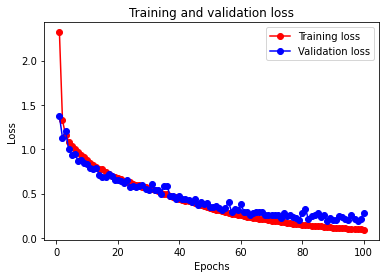

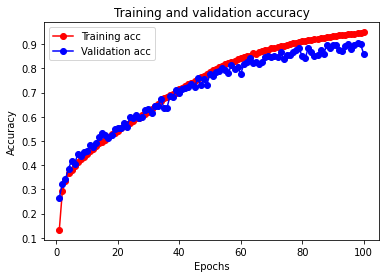

In [19]:
# plot training and validation loss and acc

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", marker="o", label="Training loss")
plt.plot(epochs, val_loss_values, "b", marker="o",label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", marker="o", label="Training acc")
plt.plot(epochs, val_acc, "b", marker="o", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Check translation performance on val dataset

In [20]:
# sample some sentences as test data to see performance

test_input_texts = [pair[0] for pair in val_pairs]
test_output_texts = [pair[1] for pair in val_pairs]

# test_input_texts = [pair[0] for pair in test_pairs]

from numpy import random

num_sample = 10
idx = [random.randint(0, len(val_pairs)) for i in range(num_sample)]

for i in idx:
  input_sentence = test_input_texts[i]
  target = test_output_texts[i]

  print("idx =", i)
  print("-> input")
  print(input_sentence)
  print("-> target")
  print(strip_markers(target))
  print("-> predicted")
  print(strip_markers(decode_sequence(input_sentence)))
  print()

idx = 401
-> input
a j a e c f a f a e c g a f c e a j a g a e c g a i a e b f b f a d c g c e c f a g c e c e a j c f c e b f 
-> target
c f a e d c g a e f c e c g a e i b f a e k b f c g c e a d ed ee a i l m ef a g j eg c f c e c e a g ej ek a j eh ei el a f h em a f g fd c f c e b f a j ff fg fh a j e fe fi
-> predicted
c f a e d c g a e f c e c e c g a e j b f b f c g c f a d m ed a i k l ee a g h ef c e c f a j eg eh ei c f a g ej ek b e c f c f b f a j fd fe ff a h el em fg b f a j fh fi a k ej fj

idx = 505
-> input
a d b f a i a g c e b e a g a i c g a g a f b e b f b g c g a i a h c d b d a e a f b g c e b e b g b e 
-> target
b f c e b e a g e f c g b e b f a f i j b g a g k l c g a i h m ed c d b d b g c e a f eh ei a e ej a h ef eg ek b e b g a i el em fd a g ee fe b e a i g ff fg a d d fh
-> predicted
b f c e b e a g e f c g b e b f a f i j b g a g k l b g a i h m ed c d b d b g c e a f eh ei b e a i eg ej ek b e a i ef el em b g a f fd fe b e a i h ff fg a j d g fh

idx

### Retrain on the entire given dataset

In [25]:
train_ds_full = make_dataset(text_pairs)

In [26]:
embed_dim = 256
dense_dim = 1024
num_heads = 8
vocab_size = 100

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds_full, epochs=80)

Epoch 1/80
79/79 [==============================] - 15s 135ms/step - loss: 2.2407 - accuracy: 0.1511
Epoch 2/80
79/79 [==============================] - 11s 133ms/step - loss: 1.2948 - accuracy: 0.3004
Epoch 3/80
79/79 [==============================] - 11s 135ms/step - loss: 1.1640 - accuracy: 0.3426
Epoch 4/80
79/79 [==============================] - 11s 135ms/step - loss: 1.0612 - accuracy: 0.3734
Epoch 5/80
79/79 [==============================] - 11s 136ms/step - loss: 1.0117 - accuracy: 0.3937
Epoch 6/80
79/79 [==============================] - 11s 137ms/step - loss: 0.9571 - accuracy: 0.4144
Epoch 7/80
79/79 [==============================] - 11s 138ms/step - loss: 0.9300 - accuracy: 0.4272
Epoch 8/80
79/79 [==============================] - 11s 138ms/step - loss: 0.8818 - accuracy: 0.4455
Epoch 9/80
79/79 [==============================] - 11s 138ms/step - loss: 0.8591 - accuracy: 0.4557
Epoch 10/80
79/79 [==============================] - 11s 139ms/step - loss: 0.8312 - accura

### Save the Final Trained Model

In [37]:
transformer.save_weights('tianliu_525004380_project2_transformer_final_0.9331.weights')
transformer.save('tianliu_525004380_project2_transformer_final_0.9456.best.h5') # save in h5 format
transformer.save('tianliu_525004380_project2_transformer_final_0.9456.best')

INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_final_0.9456.best/assets


INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_final_0.9456.best/assets


### To test the trained model on the testing data

#### Setup working directory

In [ ]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the following directory to your working directory
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation/'

/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation


#### To load the pretrained model

To load the model with customized classes, like the Positional Embedding and TransformerEncoder as well as TransformerDecoder, arguments have to be passed to the custom_objects, as shown below. Also, these layers have to be defined by running the following blocks.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        
        proj_output = self.dense_proj(attention_output_2)
        
        return self.layernorm_3(attention_output_2 + proj_output)

In [ ]:
# load the model
from tensorflow import keras

transformer_loaded = keras.models.load_model(\
                                             'tianliu_525004380_project2_transformer_final.best',\
                                            #  'tianliu_525004380_project2_transformer_final_0.9601.best', \
                                             custom_objects={"PositionalEmbedding":PositionalEmbedding, \
                                                             "TransformerEncoder":TransformerEncoder, \
                                                             "TransformerDecoder":TransformerDecoder})

# # load model in h5 format
# transformer_loaded = keras.models.load_model(\
#                                             #  'tianliu_525004380_project2_transformer_final.best.h5', \
#                                              'tianliu_525004380_project2_transformer_trained_valacc0.8701.model.h5', \
#                                              custom_objects={"PositionalEmbedding":PositionalEmbedding,\
#                                                              "TransformerEncoder":TransformerEncoder, \
#                                                              "TransformerDecoder":TransformerDecoder})

In [38]:
# load the model by loading the weights

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        
        proj_output = self.dense_proj(attention_output_2)
        
        return self.layernorm_3(attention_output_2 + proj_output)

embed_dim = 256
dense_dim = 1024
num_heads = 8
vocab_size = 100

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer_loaded = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer_loaded.load_weights('tianliu_525004380_project2_transformer_final_0.9331.weights')

In [28]:
transformer_loaded = transformer

#### To run trained model on test data

Note: before run the trained model to generate translated text for the testing data, the `source_vectorization` and `target_vectorization` have to be initialized by loading the `train_pairs`, such that the test input can be vectorized using the same training input vocabulary, and the predicted results can be decoded using the same training output vocabulary.

In [ ]:
# initialize the source_vectorization and target_vectorization

import tensorflow as tf
from tensorflow.keras import layers
import string
import re
import pickle

strip_chars = string.punctuation
# print(type(strip_chars))

strip_chars = strip_chars.replace("[", "") # will keep [start] and [end] as it is to separate the marker from actual word start and end
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "") # replace punctuation characters with the empty string

vocab_size = 40 
sequence_length = 100 # max seq length seen in train data is 95

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_pairs_loaded = pickle.load(open('text_pairs', 'rb')) # load the train_pairs

train_input_texts = [pair[0] for pair in train_pairs_loaded]
train_output_texts = [pair[1] for pair in train_pairs_loaded]

source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

print(len(source_vectorization.get_vocabulary()))
print(len(target_vectorization.get_vocabulary()))

13
38


Notice that the following decoding process would be long if the testing dataset is large.

In [41]:
# preprocess the testing input data

import pickle

# test_input = pickle.load(open('DS_5_test_input', 'rb')) # load the test input data

# test_input_texts = [pair[0] for pair in train_pairs]
# test_output_texts = [strip_markers(pair[1]) for pair in train_pairs]

test_input_texts = [pair[0] for pair in val_pairs]
test_output_texts = [strip_markers(pair[1]) for pair in val_pairs]

test_input = test_input_texts[-10:]
test_output = test_output_texts[-10:]

import numpy as np
from tqdm import tqdm

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100 # here we use max seq of 100

def strip_markers(sentence):
  # strip the leading [start] and tailing [end] if existing

  words = sentence.split()
  if words[0] == "[start]":
    clean_words = words[1:]
  else:
    clean_words = words
  
  if clean_words[-1] == "[end]":
    clean_words = clean_words[:-1]
  else:
    clean_words = clean_words

  clean_text = " ".join(clean_words)
  return clean_text

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer_loaded(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence

# run the trained mode to get the predicted output
test_pred = []
for test_sentence in tqdm(test_input):
  test_pred.append(strip_markers(decode_sequence(test_sentence)))

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


#### To calculate the "accuracy for words"

From here you can calculate the test accuracy using the "accuracy for words" metric (you can use your own or use my implementation below)

In [42]:
def calculate_word_acc(target_texts, pred_texts):

  total_ct = 0
  match_ct = 0

  assert(len(target_texts)==len(pred_texts)) # assert target sentence number match pred sentence number
  
  text_pairs = zip(target_texts, pred_texts) 
  for pair in text_pairs: # loop through each sentence
    target = pair[0]
    pred = pair[1]
    print()
    print("target:", target)
    print("predic:", pred)
    
    target_words = target.split()
    pred_words = pred.split()

    total_ct += len(target_words)
    min_len = min(len(target_words), len(pred_words))
    print('target_len:', len(target_words))
    print('pred_len:', len(pred_words))
    
    m_ct = 0
    for i in range(min_len): # loop through each word
      if target_words[i] == pred_words[i]:
        m_ct += 1
        match_ct += 1
    
    print('m_ct', m_ct)
    print('match_ct', match_ct)
    print('total_ct', total_ct)
    
  word_acc = match_ct / total_ct
  return word_acc

# load the test output data
# test_output = pickle.load(open('DS_5_test_output', 'rb'))

acc = calculate_word_acc(test_output, test_pred)
print("testing accuracy is", acc)


target: b e c g b f c f c d c e a i g h i a h e f j a d d k c e a e m a d l ed b f c f a d ef eg c d a k eh ei b e c f a j ej ek el c e a d em fd a g ee fe c e c f a g fg fh a k ff fi c g a f fj fk
predic: b e c g b f c f c d c e a i g h i a h e f j a d d k c e a e m a d l ed c f a g ee ef b f c f a d eh ei c e a k ej ek c f a d el em a g eg fd c e c e c e c f a g fh fi a h ff fg fj a f fe fk
target_len: 86
pred_len: 86
m_ct 45
match_ct 45
total_ct 86

target: b f c g b f a h d e f a e g c f c g c g c e b d a e m b f a i l ed ee b g a k ef eg a d k eh c f a d ei ej a h i j ek b f a e em a e fd a d el fe c g a i h ff fg
predic: b f c g b f a h d e f a e g c f c g c g c e b d a e m b f a i l ed ee a d k ef a h i j eg b g a h h eh ei a e ej c f a d ek el a h g em b f e e fe c g c g a i fd ff fg
target_len: 74
pred_len: 77
m_ct 35
match_ct 80
total_ct 160

target: c d b f c g a k e f c f b e a i g h i c e c f a f k l b g c f b g a f ee ef a f ed eg a k m eh a d j ei c g a j d ej ek
predic